# Downloading the dataset

In [40]:
import requests

url = "https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/3f838176-6060-44db-9c91-b4acafbcb28c/download/foia-7a-fy2010-fy2019-asof-250930.csv"
response = requests.get(url)
with open("data.csv", "wb") as f:
    f.write(response.content)


# Exploratory Data Analysis

## Color Palette for charts

In [1]:
import matplotlib.pyplot as plt
# Single color override for ALL plot elements
plt.rcParams.update({
    'axes.prop_cycle': plt.cycler(color=['#F39C12']),  # Single color cycle         
})

## Data quality

### Data Properties

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
df = pd.read_csv("data.csv")

# Trimming the dataset for Approval FY 2014-2019
df = df[df["ApprovalFY"]>=2014]

# Dataset properties
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')
print(f"Number of duplicate rows: {df.duplicated().sum()}\n")
print(df.head(),'\n')
print("Column Properties:")
print("Column Name - Number of unique values - Data type")
for col in (df.columns):
    print(col, end =' - ')
    print(len(df[col].unique()), end=' - ')
    print(df[col].dtypes)

/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_56949/1400559787.py:4: DtypeWarning: Columns (14,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


The dataset has 354270 rows and 43 columns

Number of duplicate rows: 424

          AsOfDate Program                    BorrName  \
191481  2025-09-30      7A              AnthonyMaraffa   
191482  2025-09-30      7A      F.A.M. Development LLC   
191483  2025-09-30      7A   Pictures From The Sky LLC   
191484  2025-09-30      7A  GITIBIN AND ASSOCIATES INC   
191485  2025-09-30      7A               Bella Mod LLC   

                       BorrStreet       BorrCity BorrState  BorrZip  \
191481             60 Marion Road   Mattapoisett        MA     2739   
191482        430 WESTCHESTER CIR     VALPARAISO        IN    46385   
191483           222 Derby Street          Salem        MA     1970   
191484          4320 Campus Drive  NEWPORT BEACH        CA    92660   
191485  3018 Silver Cherry Circle        SUFFOLK        VA    23435   

        LocationID                 BankName  BankFDICNumber  BankNCUANumber  \
191481     32987.0             Eastern Bank         32773.0           

In [3]:
# Dropping 'AsOfDate' and 'Program' since they have only one value
df = df.drop(columns=['AsOfDate', 'Program'])
df.reset_index(drop='True')
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

# Analyzing categorical columns
cols = ['BusinessType', 'CollateralInd',
        'RevolverStatus', 'LoanStatus', 'Subprogram', 'SoldSecondMarketInd', 'ProcessingMethod']

for col in cols:
    print(df[col].unique())

The dataset has 354270 rows and 41 columns

['INDIVIDUAL' 'CORPORATION' 'PARTNERSHIP' '        ']
['N' 'Y' nan]
[0 1]
['PIF' 'EXEMPT' 'CANCLD' 'CHGOFF' 'COMMIT' nan]
['FA$TRK (Small Loan Express)' 'Patriot Express' 'Guaranty'
 'Lender Advantage Initiative' 'Gulf Opportunity'
 'Revolving Line of Credit Exports - Sec. 7(a) (14)'
 'International Trade - Sec, 7(a) (16)' 'Standard Asset Based'
 'Community Advantage Initiative' 'Rural Lender Advantage'
 'Contract Guaranty' 'Small General Contractors - Sec. 7(a) (9)'
 'Seasonal Line of Credit']
[nan 'Y' 'N']
['SBA Express Program' 'Patriot Express Loans' 'Preferred Lenders Program'
 'Small Loan Advantage Initiative' '7a General'
 'Gulf Opportunity Pilot Loan Program' 'Preferred Lenders with EWCP'
 'International Trade Loans'
 'Standard Asset Base Working Capital Line of Credit (CAPLine)'
 'Certified Lenders Program' 'Community Advantage Initiative'
 'Export Express' '7a with EWCP' 'Rural Loan Initiative'
 'Contract Loan Line of Credit (CAPLin

### Correcting Datatypes

In [4]:
# Correcting dataype of 'ApprovalDate' and 'NAICSCode' for further analysis

df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'])
print(df['ApprovalDate'].dtype)
print(df['ApprovalDate'].head())

df['NAICSCode'] = df['NAICSCode'].astype('str')

datetime64[ns]
191481   2013-10-17
191482   2013-10-17
191483   2013-10-17
191484   2013-10-17
191485   2013-10-17
Name: ApprovalDate, dtype: datetime64[ns]


### Correcting incorrect data

In [5]:
import numpy as np
# Correcting all state columns as they show more than 50 states
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]
cols = ['BorrState','BankState', 'ProjectState']
for col in cols:
    df[col] = df[col].str.upper().str.strip()
    df[col] = df[col].where(df[col].isin(valid_states), np.nan)
    print(col,' - ',len(df[col].unique()))

df.loc[df['BusinessType'] == '        ', 'BusinessType'] = np.random.choice(['INDIVIDUAL', 'CORPORATION', 'PARTNERSHIP'])

BorrState  -  51
BankState  -  51
ProjectState  -  51


### Null Values

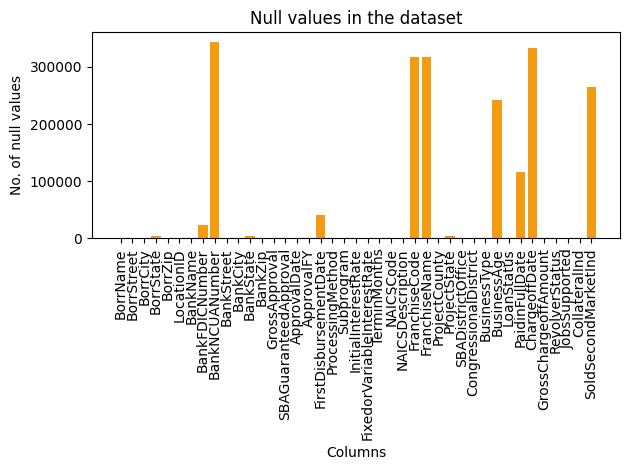

In [6]:
# Null values in each column
nulls = df.isna().sum()
plt.figure(clear=True)
plt.bar(nulls.index, nulls)
plt.title("Null values in the dataset")
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel("Columns")
plt.ylabel("No. of null values")
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
# Dropping the columns which have more than 50% of null values
df = df.drop(columns=['BankNCUANumber', 'FranchiseCode', 'FranchiseName', 'BusinessAge'])
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

The dataset has 354270 rows and 37 columns



### Handling Duplicate Rows

In [8]:
# dropping duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

Number of duplicate rows: 433
The dataset has 353837 rows and 37 columns



## Data Distribution

### Gross Approval Amount

Min: 1000.0, Max: 5000000.0
Cummulative: 140.659508793


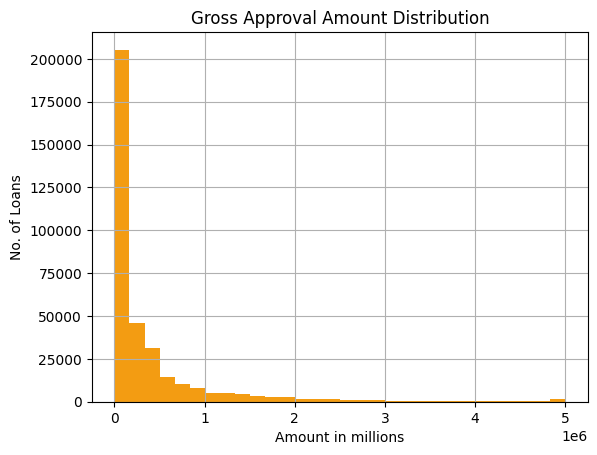

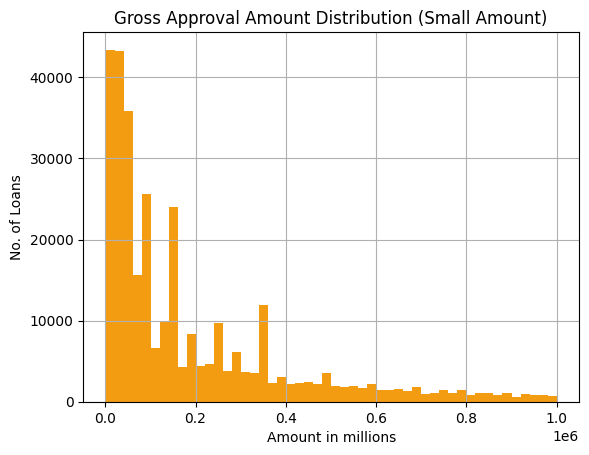

In [9]:
print(f'Min: {min(df['GrossApproval'])}, Max: {max(df['GrossApproval'])}')
print(f'Cummulative: {sum(df['GrossApproval'])/1000000000}')

# Distribution of Gross Approval Amount and SBA Guaranteed Approval Amount
df['GrossApproval'].hist(bins = 30)
plt.title("Gross Approval Amount Distribution")
plt.xlabel("Amount in millions")
plt.ylabel('No. of Loans')
plt.show()

df['GrossApproval'][df['GrossApproval'] < 1000000].hist(bins=50)
plt.title("Gross Approval Amount Distribution (Small Amount)")
plt.xlabel("Amount in millions")
plt.ylabel('No. of Loans')
plt.show()

# df['SBAGuaranteedApproval'].hist(bins=30)
# plt.title("SBA Guaranteed Approval Amount Distribution")
# plt.xlabel("Amount in millions")
# plt.ylabel('No. of Loans')
# plt.show()

# df['SBAGuaranteedApproval'][df['SBAGuaranteedApproval'] < 1000000].hist(bins=50)
# plt.title("SBA Guaranteed Approval Amount Distribution")
# plt.xlabel("Amount in millions")
# plt.ylabel('No. of Loans')
# plt.show()

### Loan Status

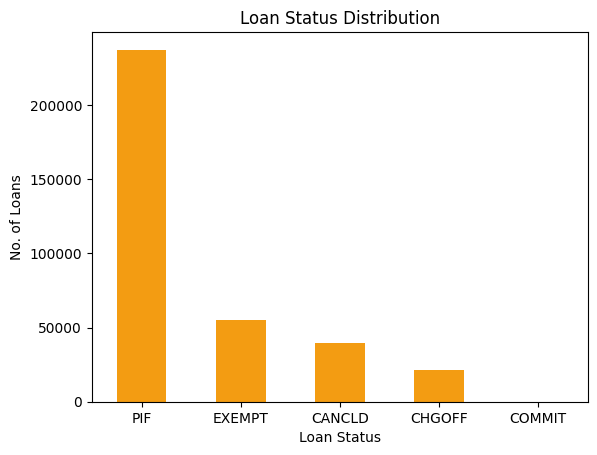

In [10]:
# Loan Status distribution
df['LoanStatus'].value_counts().plot.bar()
plt.title("Loan Status Distribution")
plt.xlabel('Loan Status')
plt.ylabel('No. of Loans')
plt.xticks(rotation = 0)
plt.show()


### Gross Defaulted Amount

Min: 11.0, Max: 4706180.93
Cummulative: 3.2808493137399997


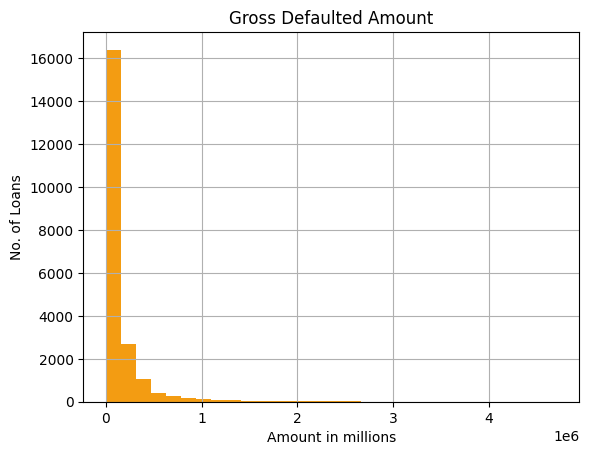

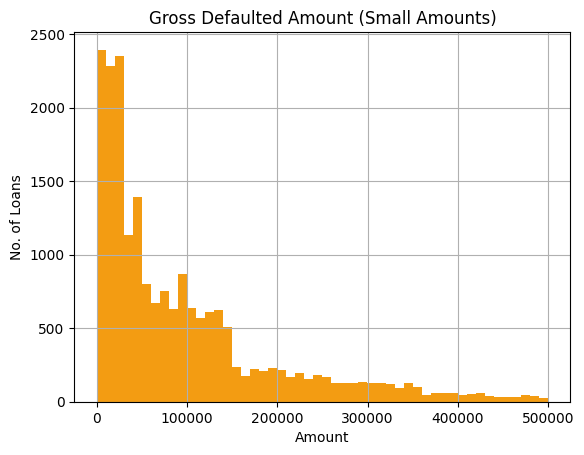

In [11]:
print(f'Min: {min(df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0])}, Max: {max(
    df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0])}')
print(f'Cummulative: {sum(df['GrossChargeoffAmount'])/1000000000}')
df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0].hist(bins=30)
plt.title("Gross Defaulted Amount")
plt.xlabel("Amount in millions")
plt.ylabel('No. of Loans')
plt.show()

df['GrossChargeoffAmount'][(df['GrossChargeoffAmount'] <= 500000) & (df['GrossChargeoffAmount'] > 0)].hist(bins=50)
plt.title("Gross Defaulted Amount (Small Amounts)")
plt.xlabel("Amount")
plt.ylabel('No. of Loans')
plt.show()

### Business Types

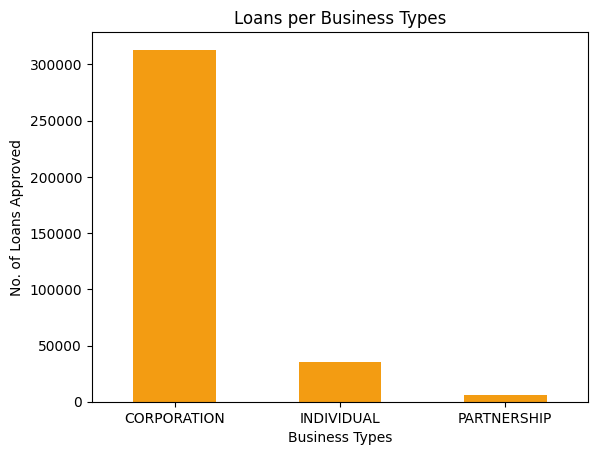

In [12]:
df['BusinessType'].value_counts().plot.bar()
plt.title("Loans per Business Types")
plt.xlabel('Business Types')
plt.ylabel('No. of Loans Approved')
plt.xticks(rotation=0)
plt.show()

### Interest Rate Types

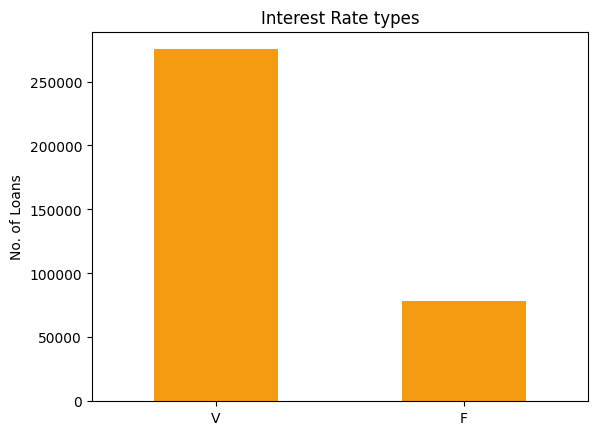

In [13]:
# Number of fixed and variable interest rates
df['FixedorVariableInterestRate'].value_counts().plot.bar()
plt.title('Interest Rate types')
plt.xlabel(None)
plt.ylabel('No. of Loans')
plt.xticks(rotation = 0)
plt.show()

### Demographic Distribution of Banks and Projects

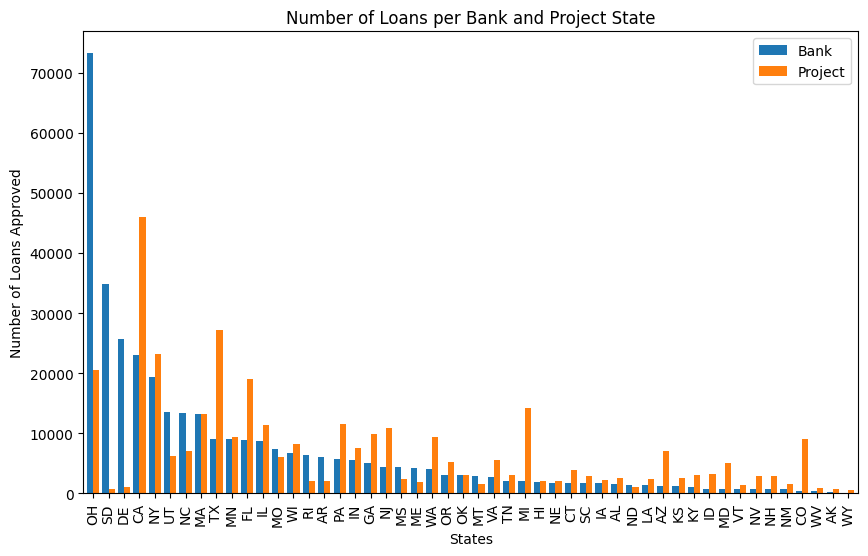

In [14]:
# Distribution of Banks and Projects
states = pd.DataFrame(df['BankState'].value_counts())
states.columns = ['Bank']
states['Project']= df['ProjectState'].value_counts()
states.sort_values(by='Bank', ascending= False, inplace=True)
plt.rcParams.update(plt.rcParamsDefault)
states.plot.bar(figsize = (10,6), width= 0.8)
plt.title("Number of Loans per Bank and Project State")
plt.xlabel('States')
plt.ylabel('Number of Loans Approved')
plt.show()
plt.rcParams.update({
    'axes.prop_cycle': plt.cycler(color=['#F39C12']),  # Single color cycle
})

## Relationships & Trends in data

### Trends over Time

In [15]:
print(df.duplicated().sum())

0


   ApprovalFY  GrossApproval(Billions)  GrossChargeoffAmount(Millions)
0        2014                19.142368                      466.974929
1        2015                23.497555                      596.301679
2        2016                24.082475                      595.421974
3        2017                25.412957                      643.636321
4        2018                25.357318                      578.665304
5        2019                23.166836                      399.849107 




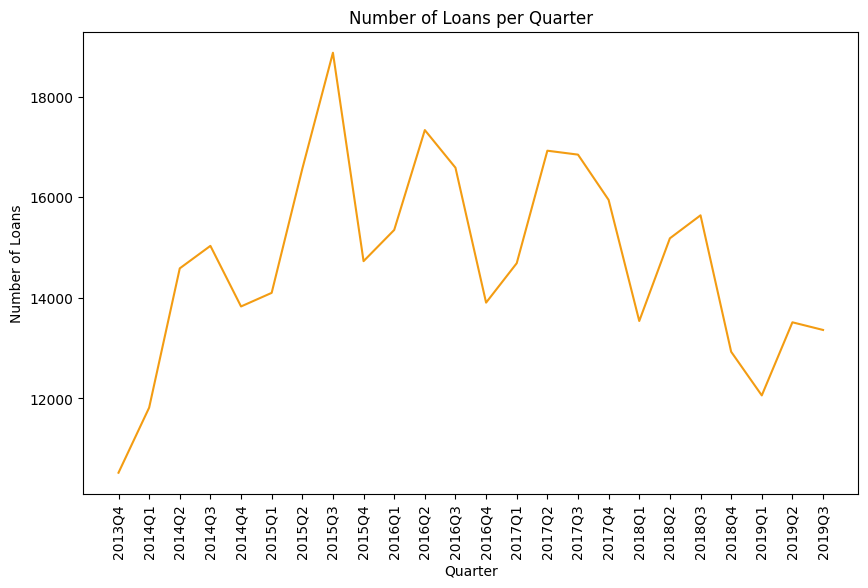

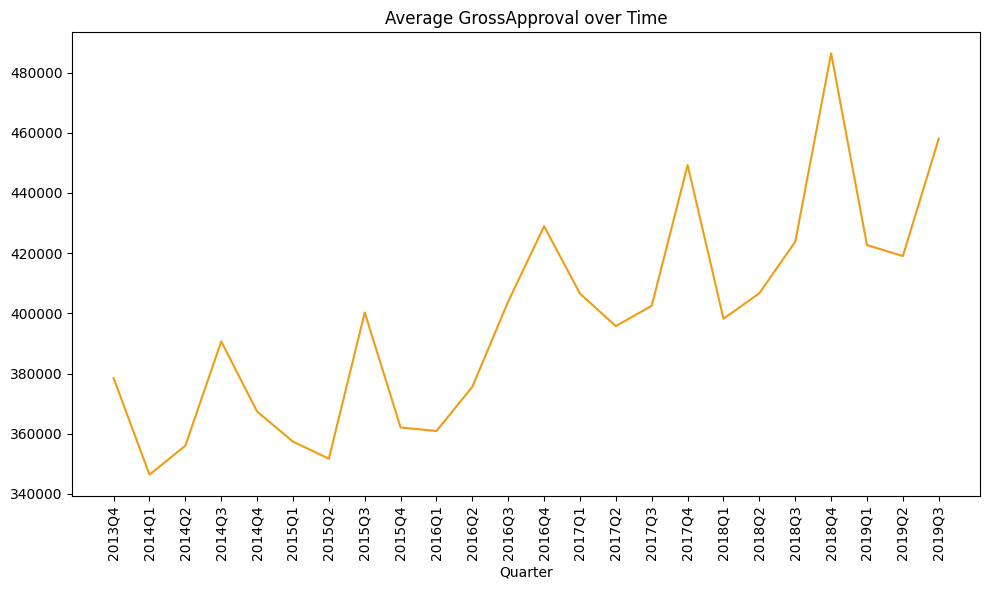

<Figure size 640x480 with 0 Axes>

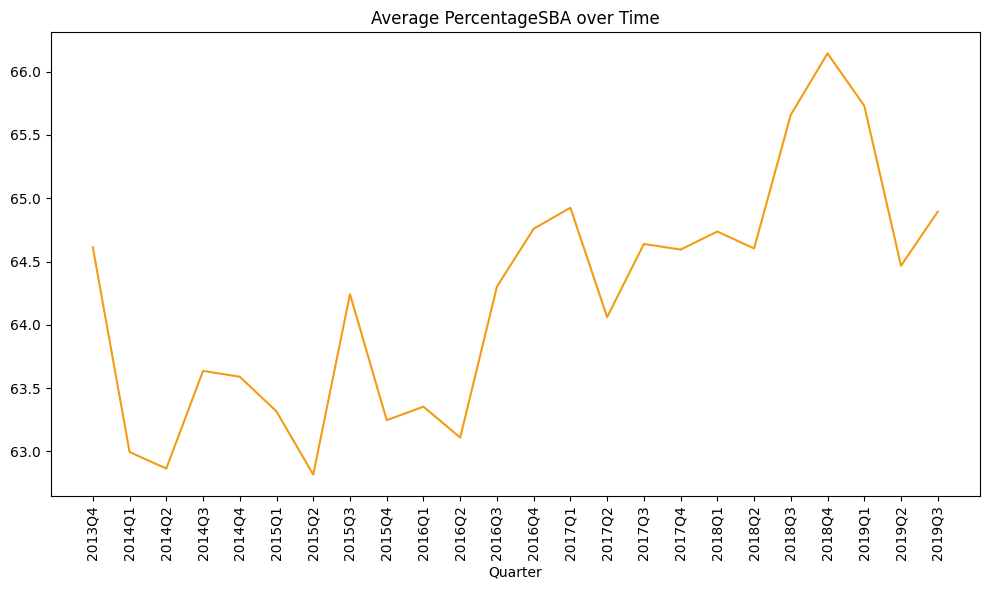

<Figure size 640x480 with 0 Axes>

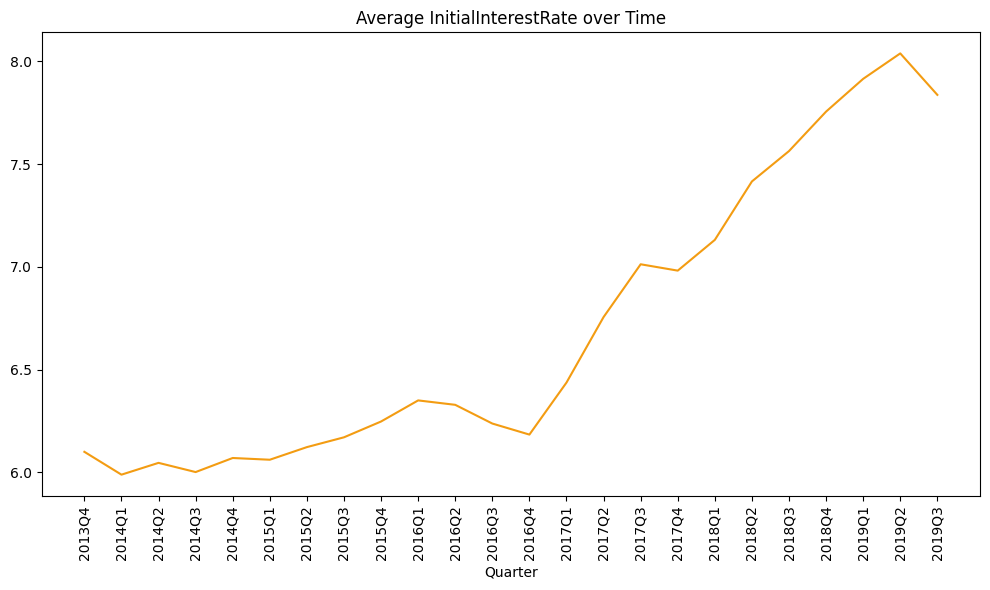

<Figure size 640x480 with 0 Axes>

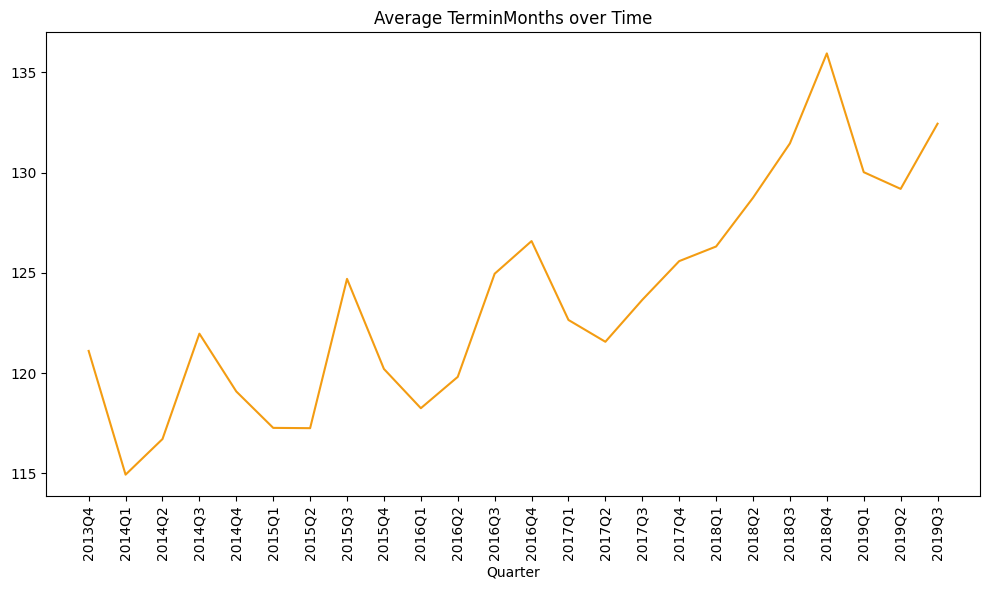

<Figure size 640x480 with 0 Axes>

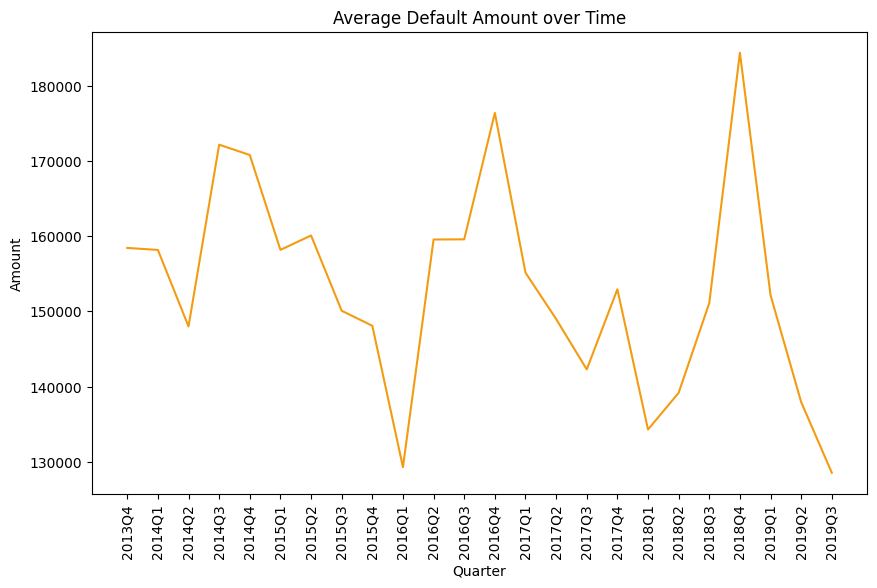

In [16]:
# Metrics per Year
Tot_per_yr = df.groupby('ApprovalFY')[
    ['GrossApproval', 'GrossChargeoffAmount']].sum().reset_index()
Tot_per_yr['GrossApproval(Billions)'] = Tot_per_yr['GrossApproval']/1000000000
Tot_per_yr['GrossChargeoffAmount(Millions)'] = Tot_per_yr['GrossChargeoffAmount']/1000000
Tot_per_yr = Tot_per_yr.drop(columns=['GrossApproval', 'GrossChargeoffAmount'])
print(Tot_per_yr,'\n\n')

# Number of Approvals over time
df['QuarterYear'] = df['ApprovalDate'].dt.to_period('Q').astype(str)
df['QuarterYear'].value_counts().sort_index().plot.line(figsize=(10,6))
plt.title('Number of Loans per Quarter')
plt.xlabel('Quarter')
plt.ylabel("Number of Loans")
plt.xticks(range(len(df['QuarterYear'].unique())), list(df['QuarterYear'].unique()),rotation = 90)
plt.show()

# Average of metrics over time
df['PercentageSBA'] = (df['SBAGuaranteedApproval'] / df['GrossApproval']) * 100
quarterly_avg = df.groupby('QuarterYear')[['GrossApproval', 'PercentageSBA', 'InitialInterestRate', 'TerminMonths']].mean().reset_index()
for col in quarterly_avg.columns[1:]:
    plt.figure(figsize=(10, 6))
    plt.plot(quarterly_avg['QuarterYear'], quarterly_avg[col])
    plt.title(f'Average {col} over Time')
    plt.xlabel('Quarter')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.figure(clear=True)

chgoff_avg = df[df['GrossChargeoffAmount']>0].groupby('QuarterYear')[
    'GrossChargeoffAmount'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(chgoff_avg['QuarterYear'], chgoff_avg['GrossChargeoffAmount'])
plt.title('Average Default Amount over Time')
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(rotation= 90)
plt.show()


### Trends over Demographics

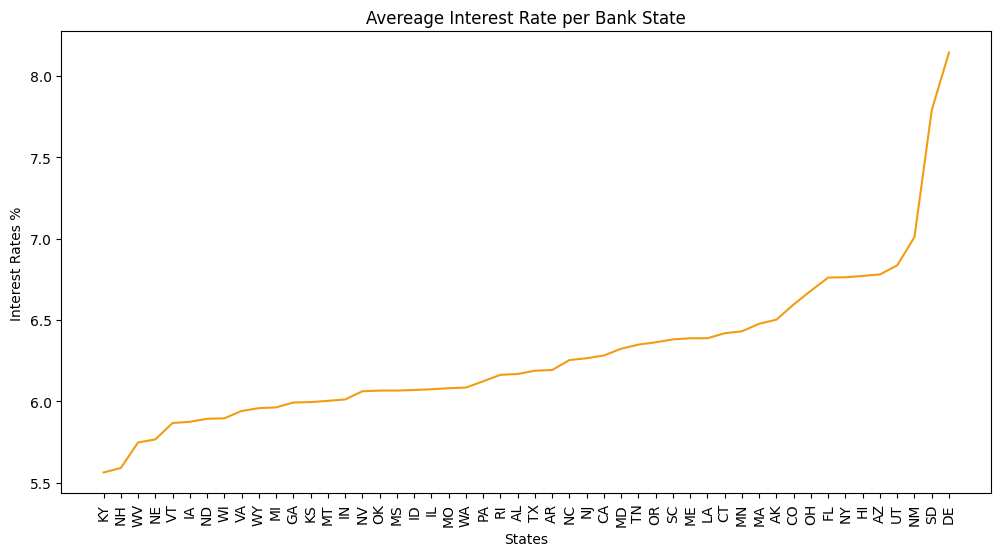

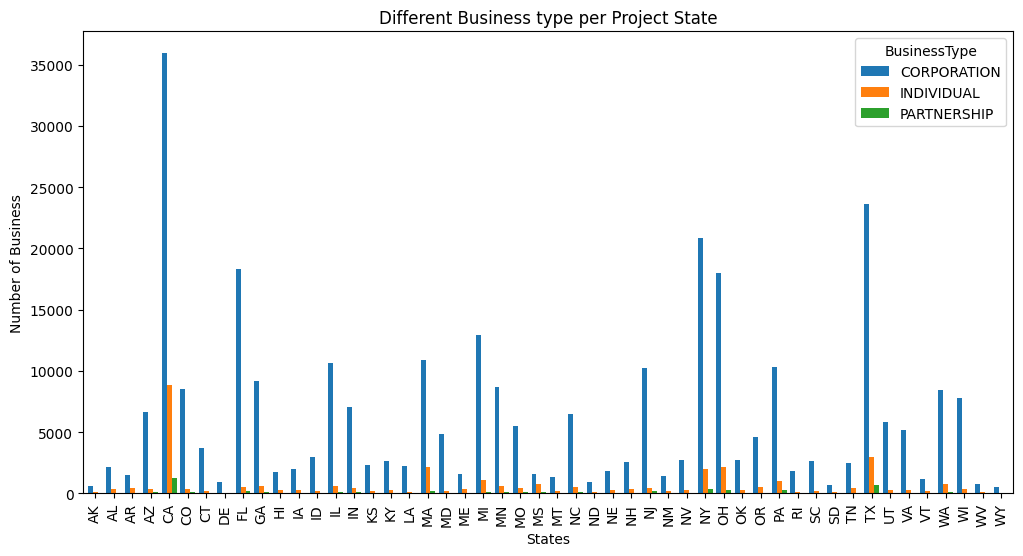

In [17]:
# Average Interest Rates per Bank State
avg_interest = df.groupby('BankState')['InitialInterestRate'].mean().sort_values()
avg_interest.plot.line(figsize=(12,6))
plt.title('Avereage Interest Rate per Bank State')
plt.xlabel("States")
plt.ylabel('Interest Rates %')
plt.xticks(range(50), list(avg_interest.index), rotation = 90)
plt.show()



# Different Business type per Project State
b_type_State = pd.crosstab(df['ProjectState'], df['BusinessType'])
plt.rcParams.update(plt.rcParamsDefault)
b_type_State.plot(kind='bar', figsize=(12,6), width = 0.8)
plt.title('Different Business type per Project State')
plt.xlabel("States")
plt.ylabel('Number of Business')
plt.show()
plt.rcParams.update({
    'axes.prop_cycle': plt.cycler(color=['#F39C12']),  # Single color cycle
})

### Trends over Business Types

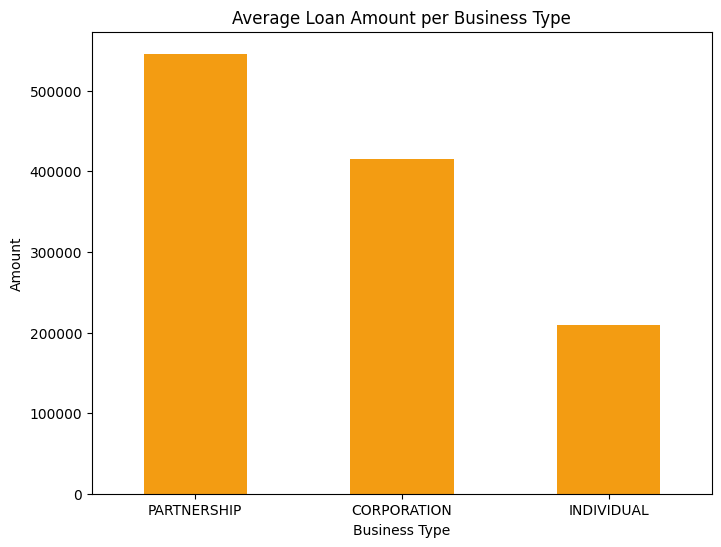

In [18]:
# Average Loan Amount per Business Type
avg_btype = df.groupby('BusinessType')[['GrossApproval', 'GrossChargeoffAmount']].mean()
avg_btype['GrossApproval'].sort_values(ascending=False).plot(kind='bar', figsize=(8,6))
plt.title("Average Loan Amount per Business Type")
plt.xlabel('Business Type')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.show()


### Default Rate Trends

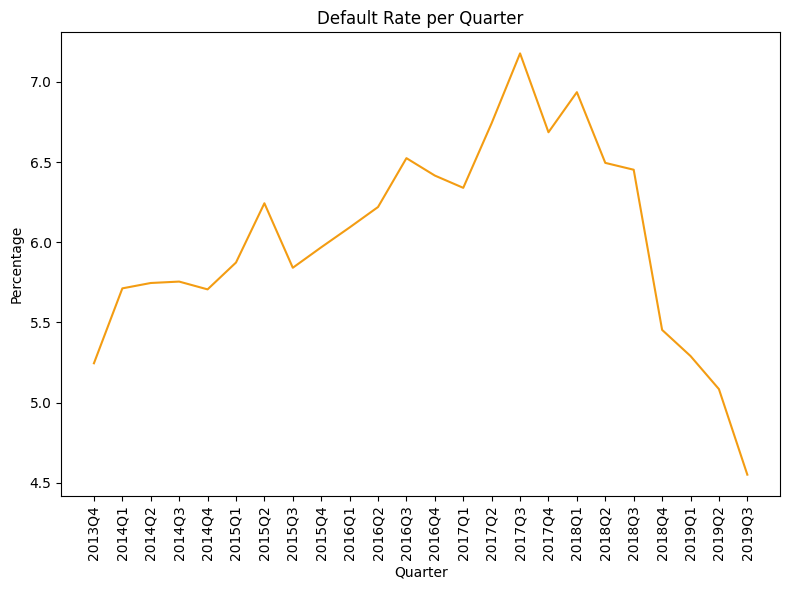

/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_56949/2558564605.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = bin_summary.groupby('GrossApproval')['is_defaulted'].mean().reset_index()


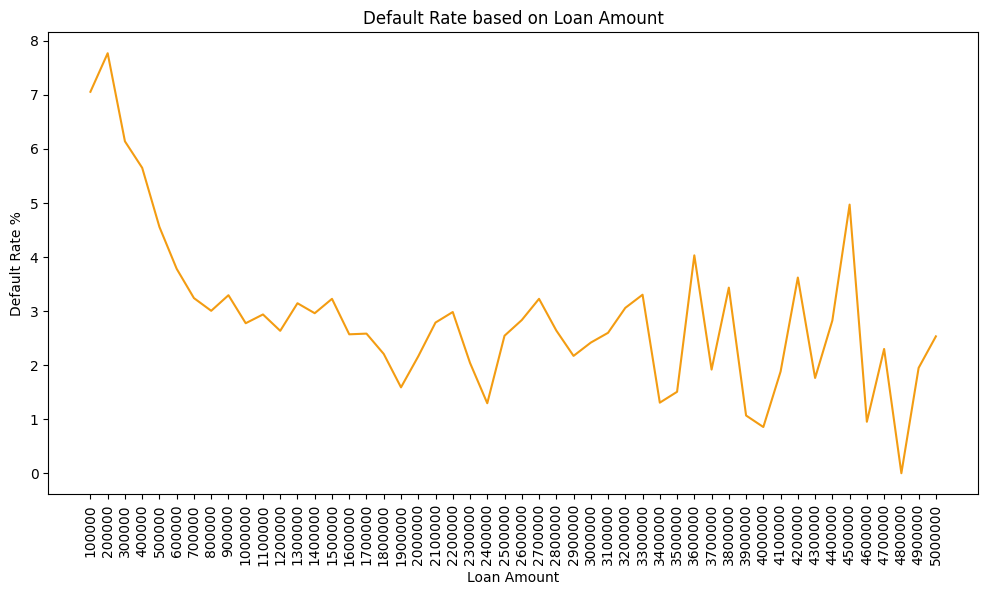

Index(['InitialInterestRate', 'isDefaulted'], dtype='object')


/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_56949/2558564605.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interest = interest.groupby('InitialInterestRate')['isDefaulted'].mean().reset_index()


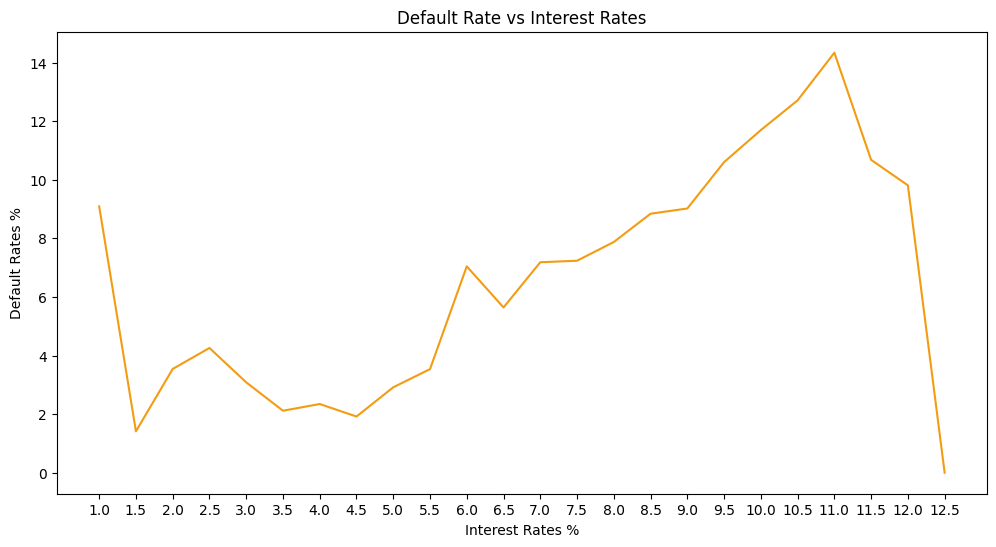

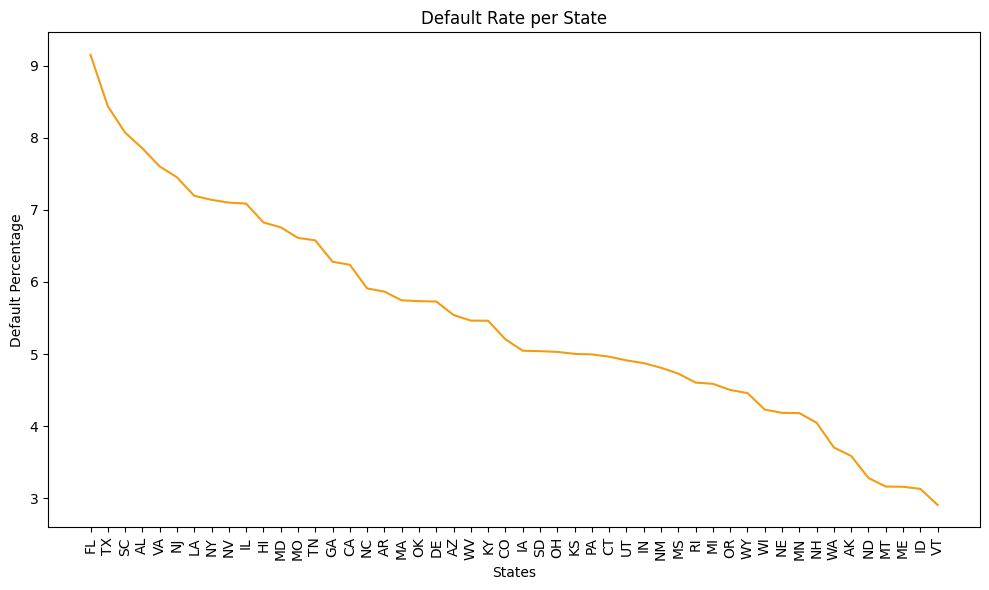

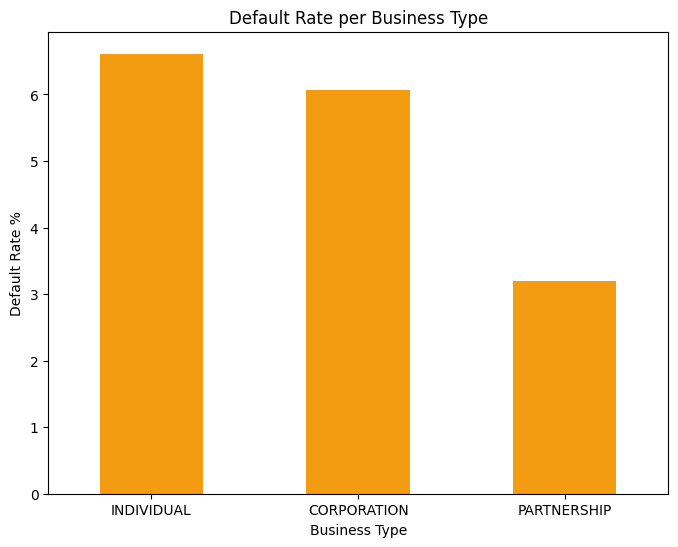

In [19]:
# Default Rate per Quarter
loan_sts = pd.crosstab(df['QuarterYear'], df['LoanStatus'])
loan_sts['TOTAL'] = loan_sts.sum(axis=1)
chgoff_rate = (loan_sts['CHGOFF']/loan_sts['TOTAL'])*100
chgoff_rate.plot(kind='line', figsize=(8, 6))
plt.title("Default Rate per Quarter")
plt.xlabel("Quarter")
plt.ylabel("Percentage")
plt.xticks(range(len(chgoff_rate)), list(chgoff_rate.index), rotation=90)
plt.tight_layout()
plt.show()

# Default Rate based on Loan Amount
df['is_defaulted'] = df['LoanStatus'].isin(['CHGOFF'])
bins = np.arange(0, max(df['GrossApproval'])+100000, 100000)
labels = [f'{int(i)+100000}' for i in bins[:-1]]
bin_summary = pd.DataFrame(pd.cut(df['GrossApproval'],bins=bins, labels= labels, right=False))
bin_summary['is_defaulted'] = df['is_defaulted']

bin_summary = bin_summary.groupby('GrossApproval')['is_defaulted'].mean().reset_index()
bin_summary['is_defaulted'] = bin_summary['is_defaulted']*100
bin_summary.plot(kind='line', x='GrossApproval', figsize=(12,6))
plt.title('Default Rate based on Loan Amount')
plt.xlabel("Loan Amount")
plt.ylabel("Default Rate %")
plt.xticks(range(0, len(bin_summary)), bin_summary['GrossApproval'], rotation=90)
plt.legend().remove()
plt.show()

# Default Rate based on interest
int_bins = np.arange(1, max(df['InitialInterestRate']),0.5)
interest = pd.DataFrame(pd.cut(df['InitialInterestRate'], bins = int_bins, labels=int_bins[:-1], right=False))
interest['isDefaulted'] = df['is_defaulted']
print(interest.columns)
interest = interest.groupby('InitialInterestRate')['isDefaulted'].mean().reset_index()
interest['isDefaulted'] *= 100
interest.plot(kind='line', x='InitialInterestRate', figsize=(12,6))
plt.title('Default Rate vs Interest Rates')
plt.xlabel('Interest Rates %')
plt.ylabel('Default Rates %')
plt.xticks(range(len(interest)), int_bins[:-1])
plt.legend().remove()
plt.show()

# Default Rate per Project State
loan_sts_bank = pd.crosstab(df['ProjectState'], df['LoanStatus'])
chgoff_rate = pd.DataFrame(
    (loan_sts_bank['CHGOFF']/loan_sts_bank.sum(axis=1))*100)
chgoff_rate.columns = ['ProjectRates']
chgoff_rate.sort_values(by='ProjectRates', ascending=False, inplace=True)
chgoff_rate.plot(kind='line', figsize=(10, 6))
plt.title("Default Rate per State")
plt.xlabel("States")
plt.ylabel("Default Percentage")
plt.xticks(range(len(chgoff_rate)), list(chgoff_rate.index), rotation=90)
plt.legend().remove()
plt.tight_layout()
plt.show()

# Default rate per Business Type
loan_sts = pd.crosstab(df['BusinessType'], df['LoanStatus'])
chgoff_rate = (loan_sts['CHGOFF']/loan_sts.sum(axis=1))*100
chgoff_rate.sort_values(ascending=False, inplace=True)
chgoff_rate.plot(kind='bar', figsize=(8, 6))
plt.title('Default Rate per Business Type')
plt.xlabel('Business Type')
plt.ylabel('Default Rate %')
plt.xticks(rotation=0)
plt.show()

# Data Wrangling and Feature Engineering

## Data Cleaning

### Remove irrelevant columns

In [20]:
print(df.columns)

Index(['BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip',
       'LocationID', 'BankName', 'BankFDICNumber', 'BankStreet', 'BankCity',
       'BankState', 'BankZip', 'GrossApproval', 'SBAGuaranteedApproval',
       'ApprovalDate', 'ApprovalFY', 'FirstDisbursementDate',
       'ProcessingMethod', 'Subprogram', 'InitialInterestRate',
       'FixedorVariableInterestRate', 'TerminMonths', 'NAICSCode',
       'NAICSDescription', 'ProjectCounty', 'ProjectState',
       'SBADistrictOffice', 'CongressionalDistrict', 'BusinessType',
       'LoanStatus', 'PaidinFullDate', 'ChargeoffDate', 'GrossChargeoffAmount',
       'RevolverStatus', 'JobsSupported', 'CollateralInd',
       'SoldSecondMarketInd', 'QuarterYear', 'PercentageSBA', 'is_defaulted'],
      dtype='object')


In [21]:
# Remove redundant and irrelevant columns
cols = ['BorrName', 'BorrStreet', 'BorrCity', 'BorrZip', 'BorrState', 'LocationID', 'BankName', 'BankFDICNumber', 'BankStreet', 'BankCity', 'BankZip', 'SBAGuaranteedApproval', 
        'ApprovalDate', 'FirstDisbursementDate', 'Subprogram', 'NAICSDescription', 'ProjectCounty', 'SBADistrictOffice', 'CongressionalDistrict', 'LoanStatus', 'PaidinFullDate', 'SoldSecondMarketInd', 'QuarterYear', 'ChargeoffDate', 'GrossChargeoffAmount']

df.drop(columns=cols, inplace=True)
print("Column Properties:")
print("Column Name - Number of unique values - Data type")
for col in (df.columns):
    print(col, end=' - ')
    print(len(df[col].unique()), end=' - ')
    print(df[col].dtypes)

print(df.duplicated().sum())

Column Properties:
Column Name - Number of unique values - Data type
BankState - 51 - object
GrossApproval - 17912 - float64
ApprovalFY - 6 - int64
ProcessingMethod - 20 - object
InitialInterestRate - 1398 - float64
FixedorVariableInterestRate - 2 - object
TerminMonths - 336 - int64
NAICSCode - 1095 - object
ProjectState - 51 - object
BusinessType - 3 - object
RevolverStatus - 2 - int64
JobsSupported - 239 - float64
CollateralInd - 3 - object
PercentageSBA - 353 - float64
is_defaulted - 2 - bool
3283


### Handling Null Values

In [22]:
nulls = df.isna().sum()
print(nulls)

BankState                      3490
GrossApproval                     0
ApprovalFY                        0
ProcessingMethod                  0
InitialInterestRate               0
FixedorVariableInterestRate       0
TerminMonths                      0
NAICSCode                         0
ProjectState                   3698
BusinessType                      0
RevolverStatus                    0
JobsSupported                     2
CollateralInd                     5
PercentageSBA                     0
is_defaulted                      0
dtype: int64


In [23]:
df.dropna(subset=['BankState', 'ProjectState'],inplace=True)
df.fillna({'JobsSupported':int(df['JobsSupported'].mean())}, inplace=True)
df.fillna({'CollateralInd':'N'},inplace=True)
nulls = df.isna().sum()
print(nulls)

BankState                      0
GrossApproval                  0
ApprovalFY                     0
ProcessingMethod               0
InitialInterestRate            0
FixedorVariableInterestRate    0
TerminMonths                   0
NAICSCode                      0
ProjectState                   0
BusinessType                   0
RevolverStatus                 0
JobsSupported                  0
CollateralInd                  0
PercentageSBA                  0
is_defaulted                   0
dtype: int64


### Handling Duplicates

In [24]:
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

3254


## Feature Engineering

### Encoding Categorical Features

In [25]:
from sklearn.preprocessing import TargetEncoder

# One-hot Encoding binary columns
cols = ['FixedorVariableInterestRate', 'CollateralInd']
for col in cols:
    df[col] = pd.get_dummies(
        df[col], prefix='', drop_first=True).astype(int)

# Target encode the categorical features
targetEncoder = TargetEncoder(
    cv= 5,
    smooth= 5,
    target_type= 'binary'
)

cols = df.select_dtypes(include='object').columns
cat_encoded = targetEncoder.fit_transform(df[cols], df['is_defaulted'])
cat_encoded = pd.DataFrame(cat_encoded, columns= cols, index=df.index)

for col in cols:
    df[col] = cat_encoded[col]

for col in (df.columns):
    print(col, end=' - ')
    print(df[col].dtypes)

BankState - float64
GrossApproval - float64
ApprovalFY - int64
ProcessingMethod - float64
InitialInterestRate - float64
FixedorVariableInterestRate - int64
TerminMonths - int64
NAICSCode - float64
ProjectState - float64
BusinessType - float64
RevolverStatus - int64
JobsSupported - float64
CollateralInd - int64
PercentageSBA - float64
is_defaulted - bool


### Correlation Analysis

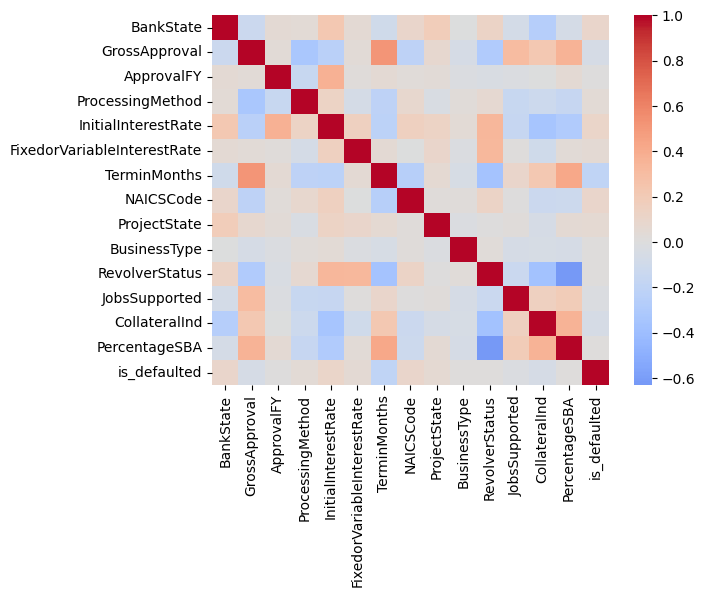

In [26]:
import seaborn as sns

# Changing the dtype of target column
df['is_defaulted'] = df['is_defaulted'].astype(int)

# Correlation Heatmap for numerical columns
numeric_cols = df.select_dtypes(include=['integer', 'float']).columns
corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, center=0, cmap='coolwarm')
plt.show()

# Model Initial Training and Testing

### Checking for final duplicates

In [27]:
if df.duplicated().sum():
    df= df.drop_duplicates().reset_index(drop=True)

### Model Training

In [28]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')


y = df['is_defaulted']
X = df.drop(columns=['is_defaulted'])

# Splitting the Training and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42, stratify=y )

# StratifiedKFold for CV scores on training data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGB Classifier model
def xgb_cv(X_train,y_train):
    xgb_model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc',
        verbosity=0
    )

    cv_scores_XGB = cross_val_score(xgb_model, X_train, y_train, cv= skf, scoring= 'roc_auc' )
    print(f'XGB Scores on Training - {cv_scores_XGB.mean()}')
    return xgb_model

# Logistic Regression
def lr_cv(X_train, y_train):
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scale numeric only
        ('classifier', LogisticRegression(
            penalty='elasticnet',  # L1+L2 regularization
            l1_ratio=0.5,         # Balance L1/L2
            C=1.0,                # Regularization strength
            max_iter=1000,
            random_state=42,
            solver='saga'         # Handles elasticnet
        ))
    ])

    cv_scores_LR = cross_val_score(lr_pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    print(f'Logistic Regression Scores on Training - {cv_scores_LR.mean()}')
    return lr_pipeline

### Model Testing

In [29]:
# XGB Model
def xgb_test(xgb_model, X_train, y_train, X_test, y_test):
    xgb_model.fit(X_train,y_train)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:,1]
    xgb_test_auc = roc_auc_score(y_test,xgb_pred_proba)
    print(f'XGB Test Scores: {xgb_test_auc}')
    return xgb_pred_proba

# Logistic Regression
def lr_test(lr_pipeline, X_train, y_train, X_test, y_test):
    lr_pipeline.fit(X_train, y_train)
    lr_pred_proba = lr_pipeline.predict_proba(X_test)[:,1]
    lr_test_auc = roc_auc_score(y_test, lr_pred_proba)
    print(f'Logistic Regression Test Scores: {lr_test_auc}')
    return lr_pred_proba

# Simple weighted Ensemble
def ensemble_test(xgb_pred_proba, lr_pred_proba):
    ensemble_proba = 0.95*xgb_pred_proba + 0.05 * lr_pred_proba
    ensemble_auc = roc_auc_score(y_test, ensemble_proba)
    print(f'Weighted Ensemble Scores: {ensemble_auc}')

### Model scores in training and testing

In [30]:
# Model Scores
xgb_model = xgb_cv(X_train, y_train)
lr_pipe = lr_cv(X_train, y_train)
print("\n")
xgb = xgb_test(xgb_model, X_train, y_train, X_test, y_test)
lr = lr_test(lr_pipe, X_train, y_train, X_test, y_test)
ensemble_test(xgb, lr)

XGB Scores on Training - 0.9780352297574437
Logistic Regression Scores on Training - 0.8839248951894548


XGB Test Scores: 0.9770648975279849
Logistic Regression Test Scores: 0.8819475085722902
Weighted Ensemble Scores: 0.9768572929142129


The model scores in training and testing does not have significant difference thus rules out overfitting. Yet, the XGB scores are suspiciously high.

# Post-Processing 

### Checking for irregularities

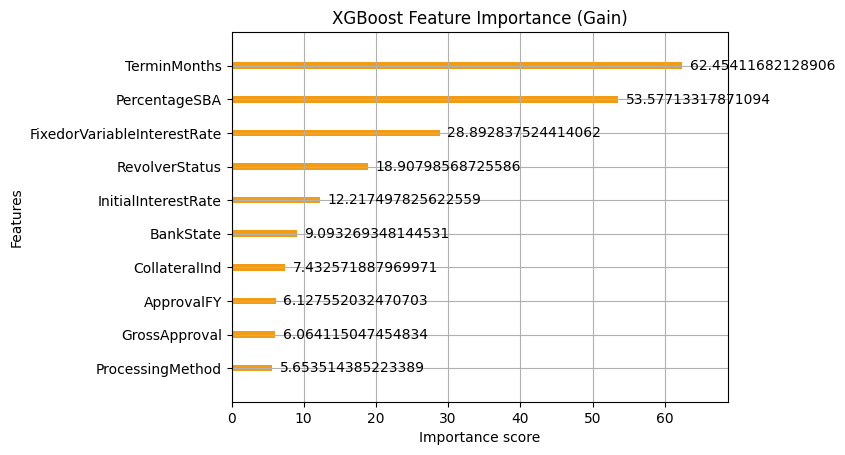

In [31]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot by 'Gain'
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

The feature 'TerminMonths' have the highest Gain. To check if this induces a cardinality bias, the feature is going to be binned into four categorical values (Short, Standard, Intermediate, and Long)

### Model Scores after binning 'TerminMonths'

In [32]:
# Binning 'TerminMonths'
bins = [0, 36, 84, 180, np.inf]
labels = ['Short', 'Standard', 'Intermediate', 'Long']
df['TermCategory'] = pd.cut(df['TerminMonths'], bins=bins, labels=labels)

df = pd.get_dummies(df, columns=['TermCategory'], prefix='LoanTerm')

df.drop(columns=['TerminMonths'], inplace=True)

XGB Scores on Training - 0.856055747221556
Logistic Regression Scores on Training - 0.8211688877373925

XGB Test Scores: 0.8542310977886853
Logistic Regression Test Scores: 0.8206057179569339
Weighted Ensemble Scores: 0.8550195081296076


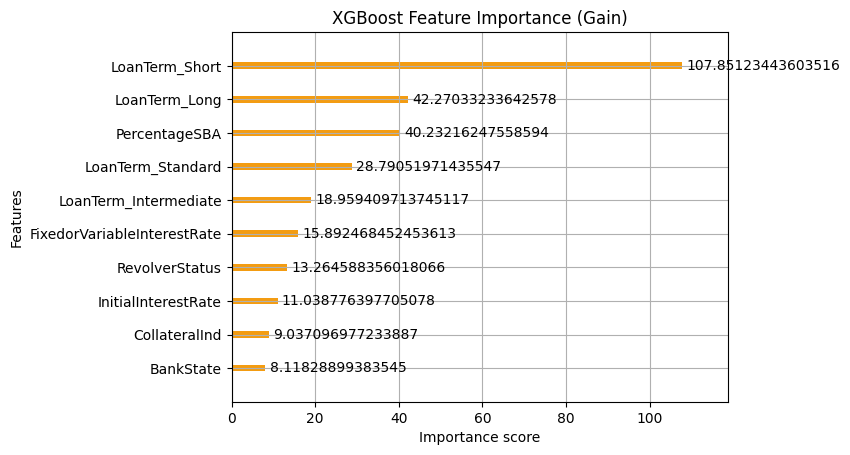

In [33]:
y = df['is_defaulted']
X = df.drop(columns=['is_defaulted'])

# Splitting the Training and Test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Training the models
xgb_model= xgb_cv(X_train,y_train)
lr_pipe = lr_cv(X_train,y_train)

print()

# Testing the models
xgb = xgb_test(xgb_model,X_train, y_train, X_test, y_test)
lr = lr_test(lr_pipe, X_train, y_train, X_test, y_test)
ensemble_test(xgb, lr)

# Plot by 'Gain'
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

The significant drop in model scores from ~0.97 to ~0.85 shows that 'TerminMonths' was inducing a cardinality bias.

After binning, the feature 'LoanTerm_Short' has higher Gain showing irregularity. Thus the feature is dropped and then the model scores are compared.

### Model Scores after dropping 'LoanTerm_Short'

In [34]:
y = df['is_defaulted']
X = df.drop(columns=['is_defaulted', 'LoanTerm_Short'])

# Splitting the Training and Test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Training the models
xgb_model = xgb_cv(X_train, y_train)
lr_pipe = lr_cv(X_train, y_train)

print()

# Testing the models
xgb = xgb_test(xgb_model, X_train, y_train, X_test, y_test)
lr = lr_test(lr_pipe, X_train, y_train, X_test, y_test)
ensemble_test(xgb, lr)


XGB Scores on Training - 0.8559621505681138
Logistic Regression Scores on Training - 0.8211134192485086

XGB Test Scores: 0.8535203801351473
Logistic Regression Test Scores: 0.8204983207048739
Weighted Ensemble Scores: 0.8542137823674324


There is no significant change in the model scores before and after removing 'LoanTerm_Short', thus it can be retained.

# Final Model Training and Testing

### Splitting the Dataset into Train and Test set

In [35]:
y = df['is_defaulted']
X = df.drop(columns=['is_defaulted'])

# Splitting the Training and Test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

### Hyperparameter Tuning using optuna

In [45]:
import optuna

# XGBoost study
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc').mean()


study_xgb = optuna.create_study(
    direction='maximize', study_name='XGBoost Study')
study_xgb.optimize(xgb_objective, n_trials=50)

# Logistic Regression Study
def lr_objective(trial):
    params = {
        'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 0.9),
        'C': trial.suggest_float('C', 0.01, 10, log=True),
        'penalty': 'elasticnet',
        'max_iter': 1000,
        'solver': 'saga',
        'random_state': 42
    }

    pipeline = Pipeline([('scaler', StandardScaler()),
                        ('classifier', LogisticRegression(**params))])
    return cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc').mean()


study_lr = optuna.create_study(direction='maximize', study_name=' LR Study')
study_lr.optimize(lr_objective, n_trials=50)

[I 2025-12-25 17:40:07,310] A new study created in memory with name: XGBoost Study
[I 2025-12-25 17:40:33,143] Trial 0 finished with value: 0.8460938699775313 and parameters: {'n_estimators': 646, 'learning_rate': 0.10190234791840098, 'max_depth': 10, 'subsample': 0.9458626849941278, 'colsample_bytree': 0.9949519207171234, 'reg_alpha': 5.927584429062245, 'reg_lambda': 7.721643795366232}. Best is trial 0 with value: 0.8460938699775313.
[I 2025-12-25 17:40:40,951] Trial 1 finished with value: 0.8391502114940114 and parameters: {'n_estimators': 603, 'learning_rate': 0.015257522741769563, 'max_depth': 3, 'subsample': 0.9060622658755272, 'colsample_bytree': 0.8777775637422632, 'reg_alpha': 4.932938514401354, 'reg_lambda': 8.02747535502818}. Best is trial 0 with value: 0.8460938699775313.
[I 2025-12-25 17:40:55,936] Trial 2 finished with value: 0.8449380205481442 and parameters: {'n_estimators': 577, 'learning_rate': 0.22807587008975302, 'max_depth': 7, 'subsample': 0.9469779150228382, 'cols

### Model Training with hyperparameter tuning

In [36]:
# XGB Classifier
def xgb_cv_tuned(X_train, y_train):
    xgb_model = XGBClassifier(
        n_estimators= 1095, 
        learning_rate= 0.012627503438965453,
        max_depth= 9,
        subsample= 0.9414590649229682,
        colsample_bytree= 0.9366821373772263,
        reg_alpha= 6.3859275763839065,
        reg_lambda = 3.447871900436414,
        verbose=0
    )

    cv_scores_XGB = cross_val_score(
        xgb_model, X_train, y_train, cv=skf, scoring='roc_auc')
    print(f'XGB Scores on Training after tuning - {cv_scores_XGB.mean()}')
    return xgb_model

# Logistic Regression


def lr_cv_tuned(X_train, y_train):
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scale numeric only
        ('classifier', LogisticRegression(
            penalty='elasticnet',
            l1_ratio= 0.38555219934081186,
            C= 9.97674891717797,
            max_iter=1000,
            random_state=42,
            solver='saga'
        ))
    ])

    cv_scores_LR = cross_val_score(
        lr_pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    print(
        f'Logistic Regression Scores on Training after tuning - {cv_scores_LR.mean()}')
    return lr_pipeline

### Model scores in Training and Testing

In [37]:
# Model Scores
xgb_tuned = xgb_cv_tuned(X_train, y_train)
lr_tuned = lr_cv_tuned(X_train, y_train)
print()
xgb = xgb_test(xgb_tuned, X_train, y_train, X_test, y_test)
lr = lr_test(lr_tuned, X_train, y_train, X_test, y_test)
ensemble_test(xgb, lr)

XGB Scores on Training after tuning - 0.8595289825692802
Logistic Regression Scores on Training after tuning - 0.8211748425522367

XGB Test Scores: 0.8579346084562226
Logistic Regression Test Scores: 0.8206118645266425
Weighted Ensemble Scores: 0.8580214400309361


### SHAP Insights

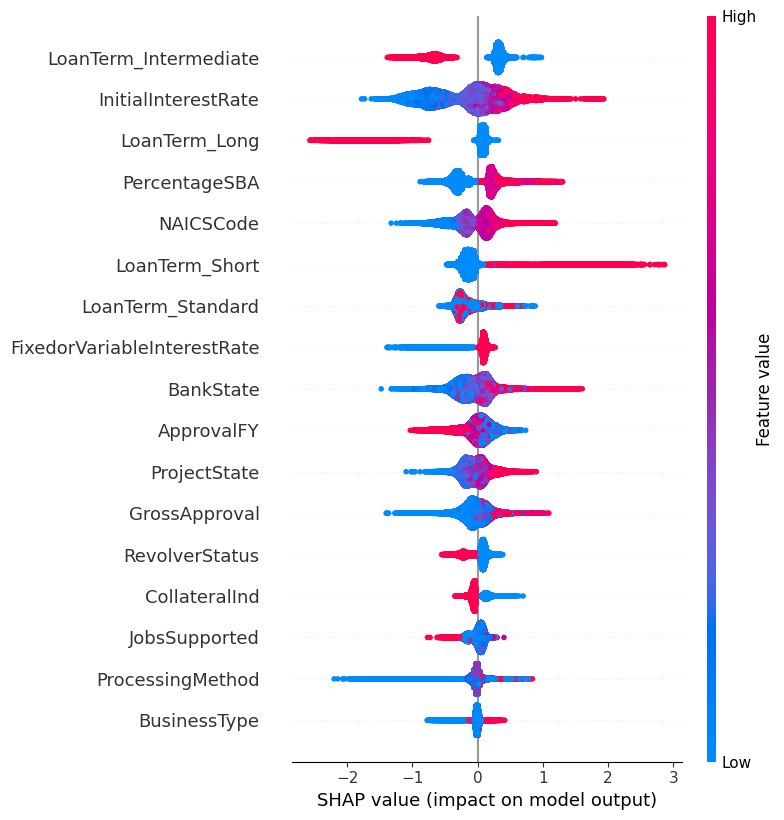

In [38]:
import shap
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X_test)

# Summary plot: Shows impact and direction
shap.summary_plot(shap_values, X_test)

# Bonus Testing (2010-2014 data)

### Data Cleaning

In [ ]:
df = pd.read_csv("data.csv")
df = df[df["ApprovalFY"] < 2014]

valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]
cols = ['BankState', 'ProjectState']
for col in cols:
    df[col] = df[col].str.upper().str.strip()
    df[col] = df[col].where(df[col].isin(valid_states), np.nan)

df.loc[df['BusinessType'] == '        ', 'BusinessType'] = np.random.choice(
    ['INDIVIDUAL', 'CORPORATION', 'PARTNERSHIP'])

df['NAICSCode'] = df['NAICSCode'].astype('str')

df['PercentageSBA'] = (df['SBAGuaranteedApproval'] / df['GrossApproval']) * 100
df['is_defaulted'] = df['LoanStatus'].isin(['CHGOFF'])

cols = ['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrZip', 'BorrState', 'LocationID', 'BankName', 'BankFDICNumber', 'BankStreet', 'BankCity', 'BankZip', 'SBAGuaranteedApproval',
        'ApprovalDate', 'FirstDisbursementDate', 'Subprogram', 'NAICSDescription', 'ProjectCounty', 'SBADistrictOffice', 'CongressionalDistrict', 'LoanStatus', 'PaidinFullDate', 'SoldSecondMarketInd', 'ChargeoffDate', 'GrossChargeoffAmount', 'BankNCUANumber', 'FranchiseCode', 'FranchiseName', 'BusinessAge']

df.drop(columns=cols, inplace=True)

nulls = df.isna().sum()
print(nulls)

BankState  -  51
ProjectState  -  51
BankState                      2326
GrossApproval                     0
ApprovalFY                        0
ProcessingMethod                  0
InitialInterestRate               0
FixedorVariableInterestRate       0
TerminMonths                      0
NAICSCode                         0
ProjectState                   2443
BusinessType                      0
RevolverStatus                    0
JobsSupported                     0
CollateralInd                     0
PercentageSBA                     0
is_defaulted                      0
dtype: int64


In [41]:
df.dropna(subset=['BankState', 'ProjectState'], inplace=True)
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

2945


### Feature Engineering

In [42]:
# One-hot Encoding binary columns
cols = ['FixedorVariableInterestRate', 'CollateralInd', 'RevolverStatus']
for col in cols:
    df[col] = pd.get_dummies(
        df[col], prefix='', drop_first=True).astype(int)

# Target encode the categorical features
targetEncoder = TargetEncoder(
    cv=5,
    smooth=5,
    target_type='binary'
)

cols = df.select_dtypes(include='object').columns
cat_encoded = targetEncoder.fit_transform(df[cols], df['is_defaulted'])
cat_encoded = pd.DataFrame(cat_encoded, columns=cols, index=df.index)

for col in cols:
    df[col] = cat_encoded[col]

for col in (df.columns):
    print(col, end=' - ')
    print(df[col].dtypes)

BankState - float64
GrossApproval - float64
ApprovalFY - int64
ProcessingMethod - float64
InitialInterestRate - float64
FixedorVariableInterestRate - int64
TerminMonths - int64
NAICSCode - float64
ProjectState - float64
BusinessType - float64
RevolverStatus - int64
JobsSupported - float64
CollateralInd - int64
PercentageSBA - float64
is_defaulted - bool


In [45]:
# Binning 'TerminMonths'
bins = [0, 36, 84, 180, np.inf]
labels = ['Short', 'Standard', 'Intermediate', 'Long']
df['TermCategory'] = pd.cut(df['TerminMonths'], bins=bins, labels=labels)

df = pd.get_dummies(df, columns=['TermCategory'], prefix='LoanTerm')

df.drop(columns=['TerminMonths'], inplace=True)

### Model Scores

In [46]:
y = df['is_defaulted']
X = df.drop(columns=['is_defaulted'])
xgb = xgb_test(xgb_tuned, X_train, y_train, X_test, y_test)
lr = lr_test(lr_tuned, X_train, y_train, X_test, y_test)
ensemble_test(xgb, lr)

XGB Test Scores: 0.8579346084562226
Logistic Regression Test Scores: 0.8206118645266425
Weighted Ensemble Scores: 0.8580214400309361
